In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

# Test implementation of the Udwadia-Kalaba formulation

Based on Antunes & Debut paper.
Parameters are taken from section V. _Illustrative computations_

In [5]:
# String parameters
class String():
    """
    Class representing a string. Attributes and methods are added as required.
    The string is considered pinned at the nut and free at the bridge.
    """
    def __init__(self, length, tens, rho, stiffness, int_fric, avd, bdamp):
        self.length = length
        self.tension = tens
        self.rho = rho # mass per unit length
        self.velocity = np.sqrt(self.tension/self.rho)
        self.stiffness = stiffness
        self.mass = self.length * self.rho
        self.mod_mass = self.mass / 2
        self.internal_friction = int_fric
        self.air_visc_damp = avd
        self.bend_damp = bdamp
        
    def modal_freq(self, num):
        """
        Returns the num-th modal frequency.
        
        The formula has been slightly changed so that num=0 yields the fundamental
        frequency, in accordance to python numbering.
        """
        p_n = (2*num + 1)*np.pi/(2*self.length)
        freq_n = self.velocity*p_n/(2*np.pi) * (1 + self.stiffness* p_n**2/(2*self.tension))
        return freq_n
        
    def modal_freq_arr(self, num):
        """
        Returns an array of the num first modal frequencies.
        """
        arr = []
        for n in range(0, num):
            freq_n = self.modal_freq(n)
            arr.append(freq_n)
        return np.array(arr)
    
    def modal_puls(self, num):
        """
        Returns the num-th modal pulsation.
        """
        return 2*np.pi * self.modal_freq(num)
    
    def modal_puls_arr(self, num):
        """ 
        Returns an array of the num first modal pulsations.
        """
        return 2*np.pi*self.modal_freq_arr(num)
    
    def modeshape(self, num):
        """
        Returns a lambda function of the num-th modeshape.
        """
        modeshape = lambda x: np.sin((2*num + 1)*np.pi * x/(2*self.length))
        return modeshape
    
    def modeshapes_mat(self, num_mod, num_samples):
        """
        Returns a matrix of num_mod modeshapes computed on num_samples on the String.
        """
        geom_samples = np.linspace(0, self.length, num_samples)
        modeshapes_mat = self.modeshape(0)(geom_samples)
        modeshapes_mat = modeshapes_mat[np.newaxis,:]
        for mode in range(1, num_mod):
            modeshape_vec = self.modeshape(mode)(geom_samples)
            #print(modeshape_vec[np.newaxis,:].shape, modeshapes_mat.shape)
            modeshapes_mat = np.vstack((modeshapes_mat, modeshape_vec[np.newaxis,:]))
        return modeshapes_mat
    
    def modal_damping(self, num):
        """
        Returns the num-th modal damping coefficient.
        """
        f_n = self.modal_freq(num)
        p_n = (2*num + 1)*np.pi/(2*self.length)
        numerator = self.tension*(self.internal_friction + self.air_visc_damp/(2*np.pi*f_n)) + self.bend_damp*self.stiffness*p_n**2
        denominator = 2*(self.tension + self.stiffness*p_n**2)
        return numerator/denominator
    
    def modal_damp_arr(self, num):
        """
        Returns an array of the num first modal damping coefficients.
        """
        arr = []
        for n in range(0, num):
            zeta_n = self.modal_damping(n)
            arr.append(zeta_n)
        return np.array(arr)
    
    def modal_mass_matrix(self, size):
        """
        Returns a square modal mass matrix.
        """
        mass_mat = np.eye(size)
        mass_mat = mass_mat * self.mod_mass
        return mass_mat
        
    def modal_damp_matrix(self, size):
        """
        Returns a square modal damping matrix.
        params:
            size(int): Size of the matrix.
        returns:
            damp_mat(np.array): Diagonal matrix of modal damping parameters.
        """
        damp_vec = 2 * self.mod_mass * self.modal_puls_arr(size) * self.modal_damp_arr(size)
        return np.diag(damp_vec)
    
    def modal_stiff_matrix(self, size):
        """
        Returns a square modal stiffness matrix.
        params:
            size(int): Size of the matrix.
        returns:
            damp_stif(np.array): Diagonal matrix of modal stiffness parameters.
        """
        stif_vec = self.mod_mass * np.power(self.modal_puls_arr(size), 2)
        return np.diag(stif_vec)
    
    def modal_forces(self, force, size):
        """
        Project a force field on the modeshapes.
        params:
            force(np.array): Force field on the string. It should be 1D with each point
                separated by the geometrical sampling;
            size(int): the number of modes considered.
        returns:
            mod_forces(np.array): size x 1 array of the force field projected
                on the modeshapes.
        """
        geom_samples = np.linspace(0, self.length, len(force))
        modeshapes_mat = self.modeshape(0)(geom_samples)
        for mode in range(1, size):
            modeshape_vec = self.modeshape(mode)(geom_samples)
            modeshapes_mat = np.stack((modeshapes_mat, modeshape_vec))
        mod_forces = np.dot(modeshapes_mat, force[:, np.newaxis])
        return mod_forces

In [6]:
L = 0.65
T = 73.9
rho = 3.61e-3
B = 4e-5
etaF = 7e-5
etaA = 0.9
etaB = 2.5e-2
corde = String(L, T, rho, B, etaF, etaA, etaB)

In [7]:
N = 1000

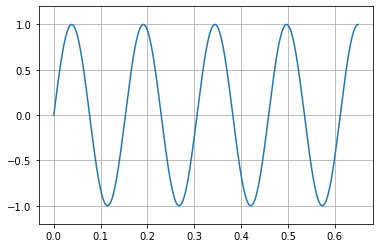

In [8]:
plt.figure()
points = np.linspace(0, corde.length, N)
plt.plot(points, corde.modeshape(8)(points))
plt.ylim(-1.2, 1.2)
plt.grid()
plt.show()

## Udwadia Kalaba, modal formulation
### Computation of the modal parameters

In [9]:
class Verlet():
    """
    Wrapper class for velocity-Verlet algorithm.
    See paper's appendix.
    """
    def __init__(self, time_step):
        self.time_step = time_step
        
    def next_displacement(self, disp, vel, acc):
        """ 
        Returns q(t_{i+1}).
        """
        return disp + self.time_step*vel + self.time_step**2 * acc
    
    def next_half_vel(self, vel, acc):
        """
        Returns \dot{q}(t_{i+1/2}).
        """
        return vel + 0.5*self.time_step*acc
    
    def next_modal_force(self, disp, half_vel, damp_mat, stif_mat, fext_vec):
        """
        Returns F(t_{i+1}).
        params:
            disp(np.array): q(t_{i+1});
            half_vel(np.array): \dot{q}(t_{i+1/2});
            damp_mat: C;
            stif_mat: K;
            fext_vec: F_\text{ext}(t_{i+1})
        returns:
            F(t_{i+1}).
        """
        #half_vel = half_vel[:, np.newaxis]
        #disp = disp[:, np.newaxis]
        a = -damp_mat@half_vel.T
        b = - stif_mat@disp.T
        #print(fext_vec.shape, a.shape, b.shape)
        return a + b  + fext_vec
    
    def next_unc_acc(self, mass_mat, force_vec):
        """
        Returns next modal accelerations for the unconstrained system,
        $\ddot{q}_u(t_{i+1})$
        params:
            mass_mat: M;
            force_vec: F(t_{i+1}).
        """
        force_vec = force_vec[:, np.newaxis]
        inv_mass = np.diag(1/mass_mat.diagonal())
        return inv_mass@force_vec
    
    def next_acc(self, acc_unc, constraint_mat):
        """
        Returns $\ddot{q}(t_{i+1}).
        """
        acc_unc = acc_unc[:, np.newaxis]
        return constraint_mat@acc_unc
    
    def next_vel(self, vel, acc, next_acc):
        """
        Returns $\dot{q}(t_{i+1}).
        """
        return vel + 0.5*self.time_step*(acc + next_acc)

In [7]:
def moore_penrose_pseudo_inverse(self, mat):
    return mat.T@np.inv(mat@mat.T)

In [11]:
class ModalUK():
    def __init__(self, string, verlet):
        """
        String object;
        ext_force_mod_mat = F_ext_modal;
        """
        self.string = string
        self.verlet = verlet

    
    def unconstrained_computing(self, simu_duration, geom_step, ext_force, num_modes):
        time_step = self.verlet.time_step
        height = int(simu_duration//time_step)
        width = int(self.string.length//geom_step)
        disp = np.zeros((height, num_modes))
        vel = np.zeros((height, num_modes))
        acc = np.zeros((height, num_modes))
        force = np.zeros((height, num_modes))
        modeshapes = self.string.modeshapes_mat(num_modes, width)
        C = self.string.modal_damp_matrix(num_modes)
        K = self.string.modal_stiff_matrix(num_modes)
        M = self.string.modal_mass_matrix(num_modes)
        excitation_duration = ext_force.shape[0]
        for i in range(1, excitation_duration):
            disp[i, :] = self.verlet.next_displacement(disp[i-1, :], vel[i-1, :], acc[i-1,:])
            half_vel = self.verlet.next_half_vel(vel[i-1,:], acc[i-1,:])
            #print(modeshapes.shape, ext_force[i,:].shape)
            modal_force = modeshapes@ext_force[i, :]
            force[i,  :] = self.verlet.next_modal_force(disp[i,:], half_vel, C, K, modal_force)
            acc[i,:] = self.verlet.next_unc_acc(M, force[i, :])[:,0]
            vel[i,:] = self.verlet.next_vel(vel[i-1,:], acc[i-1,:], acc[i,:])
        modal_force = np.zeros((num_modes))
        for i in range(excitation_duration, height):
            disp[i, :] = self.verlet.next_displacement(disp[i-1, :], vel[i-1, :], acc[i-1,:])
            half_vel = self.verlet.next_half_vel(vel[i-1,:], acc[i-1, :])
            force[i, :] = self.verlet.next_modal_force(disp[i,:], half_vel, C, K, modal_force)
            acc[i,:] = self.verlet.next_unc_acc(M, force[i, :])[:,0]
        
        return disp, vel, acc, force
        
            
            
                
        
        

In [12]:
def force_ramp(force_start, force_end, position, string_length, geom_step, duration, time_step):
    """
    Returns a matrix representing a linear force ramp.
    params:
        force_start(float): Initial value of the force in Newton (should be 0);
        force_end(float): End value of the ramp in Newtons;
        position(float): ratio between 0 and 1 indicating where the force is applied on the String;
        string_length(float): Length of the string in meters;
        geom_step(float): Space between geometrical samples in meter;
        duration(float): duration of the ramp in seconds;
        time_step(float): duration between time samples in seconds;
    returns
        force_mat(np.array): array representing the force ramp. One row per time sample
            and one column per space sample.
    """
    width = int(string_length//geom_step)
    height = int(duration//time_step)
    force_mat = np.zeros((height, width))
    pos_in_samples = int(width*position)
    ramp = np.linspace(force_start, force_end, height)
    force_mat[:, pos_in_samples] = ramp
    return force_mat

In [13]:
simu_duration = 10
time_step = 1e-5
geom_step = corde.length/100
forceExt = force_ramp(0, 5, 0.9, corde.length, geom_step, 0.01, time_step)
verlet = Verlet(time_step)
UK_algo = ModalUK(corde, verlet)

In [15]:
dis, vel, acc, force = UK_algo.unconstrained_computing(simu_duration, geom_step, forceExt, 10)

In [16]:
dis.shape

(999999, 10)

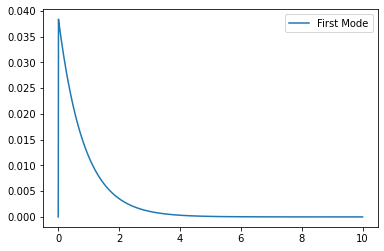

In [18]:
times = np.arange(0, simu_duration-time_step, time_step)
plt.figure()
plt.plot(times,dis[:,0], label="First Mode")
#plt.plot(times,dis[:,1], label="2nd Mode")
#plt.plot(times,dis[:,2], label="3rd Mode")
#plt.plot(times,dis[:,3], label="4th Mode")
#plt.plot(times,dis[:,4], label="5th Mode")
#plt.plot(times,dis[:,5], label="6th Mode")
#plt.plot(times,dis[:,6], label="7th Mode")
#plt.plot(times,dis[:,7], label="8th Mode")
#plt.plot(times,dis[:,8], label="9th Mode")
#plt.plot(times,dis[:,9], label="10th Mode")
plt.legend()
plt.show()

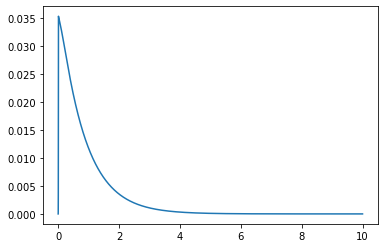

In [19]:
plt.figure()
plt.plot(times, np.sum(dis, axis=1))
plt.show()